# Machine Learning of Fashion data

## Overview
**Goal:** Find and tune the most optimal recommendation model to provide outfit recommendations based on product popularity.

Our EDA in the previous notebook gave us many insights that we will use in our machine learning pipeline below. In this notebook, we will select and engineer different features, including our target feature `popularity`, which is the popularity score of an article of clothing, based on the number of times that piece was purchased.

NOTE: because the transaction data is so large, we filtered it in the previous notebook to only have transaction data over the last 2 months.

### Load our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# data preprocessing and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize, OneHotEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# recommendation system
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

import helper

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

2024-12-06 11:56:25.125456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the transaction data from previous notebook
transactions_df = pd.read_csv("../data/newest_trans_df.csv")
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,849597003,0.012186,2
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2


In [3]:
# load the article data from previous notebook
articles_df = pd.read_csv("../data/articles_df.csv")
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


## Defining our Index
Our popularity index will be the number of times an article of clothing was purchased in the last 2 months.

In [4]:
# save purchase_count of each article_id in articles_df
articles_df["purchase_count"] = articles_df["article_id"].map(transactions_df["article_id"].value_counts())

articles_df["purchase_count"].isna().sum()


70672

In [5]:
# fill the null values of purchase_count with 0
# because that means it was never purchased in the last 2 months
articles_df["purchase_count"] = articles_df["purchase_count"].fillna(0).astype(int)

articles_df["purchase_count"].isna().sum()

0

We want to use classification models to predict popularity, so we first need to create bins to classify articles of clothing as low, medium, or high popularity based on their purchase counts.

In [6]:
# Create buckets for popularity based on purchase counts
min_val = articles_df["purchase_count"].min()
mean_val = articles_df["purchase_count"].mean()
max_val = articles_df["purchase_count"].max()

# we have to create arbitrary boundaries for the buckets since the
# purchase counts are all quite low except for some outliers
buckets = [min_val - 1, 0, mean_val, max_val + 1]
labels = ["low", "medium", "high"]

articles_df["popularity"] = pd.cut(articles_df["purchase_count"], bins=buckets, labels=labels)

articles_df["article_id"].count()

105542

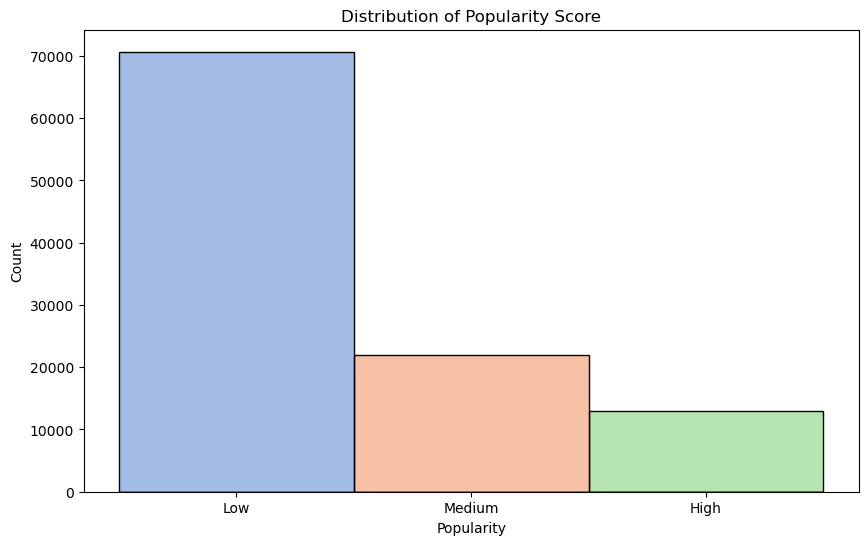

In [7]:
# Presentation Visual
# let's graph the distribution of the popularity score
plt.figure(figsize=(10, 6))

sns.histplot(articles_df, x="popularity", hue="popularity", legend=False, palette="muted")
plt.title("Distribution of Popularity Score")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ["Low", "Medium", "High"])

plt.show()

As we can see here, we have very skewed target data. We will have to address this when creating our models.

Our dataset is also still really big with 105,542 rows. In order to make the models faster, let's get a random sample of the data that still has the same distribution of popularity score.

## Feature Selection

In [8]:
# see all articles_df cols
articles_df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc',
       'purchase_count', 'popularity'],
      dtype='object')

In [9]:
# Select relevant features for classification model
articles_df = articles_df.drop(columns=["article_id", "prod_name", "product_type_name", "graphical_appearance_name",
                                        "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name",
                                        "department_name", "index_name", "index_group_name", "section_name",
                                        "garment_group_name", "detail_desc", "purchase_count"])

articles_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002,low
1,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002,high
2,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002,low
3,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017,medium
4,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017,medium


## Base Classifiers

### "Shotgun Approach": Classification Models
Since our target data is the "popularity" of an article of clothing, let's first try seeing the accuracy of classification models.

In [10]:
TARGET = ["popularity"]

X, y = articles_df.drop(columns=TARGET, axis=1), articles_df[TARGET]

In [11]:
# use encoder helper function on the text columns in X
# for easier analysis
helper.encode_strings(X)

In [12]:
# Train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        train_size=0.7,
                                        test_size=0.3,
                                        random_state=42)

In [13]:
# creating models that we want to test to see which is most optimized
# we will use this to test different X_train variations

cat_models = {
    "KNN": {
        "Estimator": KNeighborsClassifier(),
        },
    "CART": {
        "Estimator": DecisionTreeClassifier(),
        },
    "NB": {
        "Estimator": GaussianNB(),
        },
    "LOGREG": {
        "Estimator": LogisticRegression(),
        }
}

In [14]:
# test performance of different models using X_train
helper.test_models_performance(cat_models, X_train, y_train, isRegressor=False)


[MODEL TYPE: KNN]

>>>> Top Performance: 		0.7359
>>>> Average Performance: 	0.7310
>>>> Spread of Performance: 	0.0032

[MODEL TYPE: CART]

>>>> Top Performance: 		0.7015
>>>> Average Performance: 	0.6926
>>>> Spread of Performance: 	0.0062

[MODEL TYPE: NB]

>>>> Top Performance: 		0.1260
>>>> Average Performance: 	0.1252
>>>> Spread of Performance: 	0.0008

[MODEL TYPE: LOGREG]

>>>> Top Performance: 		0.7296
>>>> Average Performance: 	0.7244
>>>> Spread of Performance: 	0.0027


The decision tree is probably overfit, as the average performance is 100%. KNN or Logistic Regression may be the best performing models, but let's use a KNN and try to improve it.

In [15]:
# let's create an instance of that and tune it to have even better accuracy
knn_model = KNeighborsClassifier()

y_pred = helper.fit_predict(knn_model, X_train, y_train, X_test, y_test, isRegressor=False)

> ACCURACY: 	73.62%


### Accuracy to beat: 72.99%

## Exhaustive Machine Learning

### Tuning: Standard Scaler

In [16]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
y_pred = helper.fit_predict(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	72.79%


Scaling the data increased the accuracy to 74%!
#### Accuracy to beat: 74.12%

### Tuning: MinMax Scaler

In [18]:
# use minmax scaler
# check if that will gain better results
scaler = MinMaxScaler()
X_train_mm_scaled = scaler.fit_transform(X_train)
X_test_mm_scaled = scaler.transform(X_test)

In [19]:
y_pred = helper.fit_predict(knn_model, X_train_mm_scaled, y_train, X_test_mm_scaled, y_test, isRegressor=False)

> ACCURACY: 	72.44%


Using a MinMax scaler made the accuracy worse. Let's stick to our standard scaled data.

#### Accuracy to beat: 74.12%

### Tuning: GridSearchCV

In [20]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [21]:
# choose hyperparamters to test in the GridSearchCV
hyperparameters = {
		 "n_neighbors": [5, 10, 30, 50],
         "metric": ["euclidean", "manhattan", "minkowski"],
         "weights": ["uniform", "distance"]
}

In [22]:
tuned_model = KNeighborsClassifier()
model_tuner = GridSearchCV(tuned_model, hyperparameters, cv=10)

In [23]:
# commenting this out because it took 15 minutes to run
# model_tuner.fit(X_train_scaled, y_train)

In [24]:
# Most optimal knn model: KNeighborsClassifier(metric='manhattan', n_neighbors=30, weights='distance')

# commenting this out because this will cause an error
# if the above cell is also commented out

# optimally_tuned_classifier = model_tuner.best_estimator_

# optimally_tuned_classifier

The code for the grid search was commented out, as it took 9 minutes to run, but the optimal KNN model it returned was `KNeighborsClassifier(metric='manhattan', n_neighbors=30, weights='distance')`

From the hyperparameters fed into the GridSearchCV, we see the most optimal hyperparameters for our KNN.

In [25]:
# commenting this out because this will cause an error
# if the above cell is also commented out

# Get accuracy of the most optimal classifier
# y_pred = optimally_tuned_classifier.predict(X_test_scaled)

# helper.print_accuracy(y_test, y_pred, isRegressor=False)

This accuracy is slightly better! 

#### Accuracy to beat: 76.60%

### Accuracy Evaluation

#### Confusion Matrix & Classification Report

In [26]:
# creating an instance of the most iptimally tuned model
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=30, weights='distance')

y_pred = helper.fit_predict(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	72.76%


confusion matrix:
 [[ 2055   944   880]
 [  571 18904  1799]
 [  999  3433  2078]]

              precision    recall  f1-score   support

        high       0.57      0.53      0.55      3879
         low       0.81      0.89      0.85     21274
      medium       0.44      0.32      0.37      6510

    accuracy                           0.73     31663
   macro avg       0.61      0.58      0.59     31663
weighted avg       0.70      0.73      0.71     31663



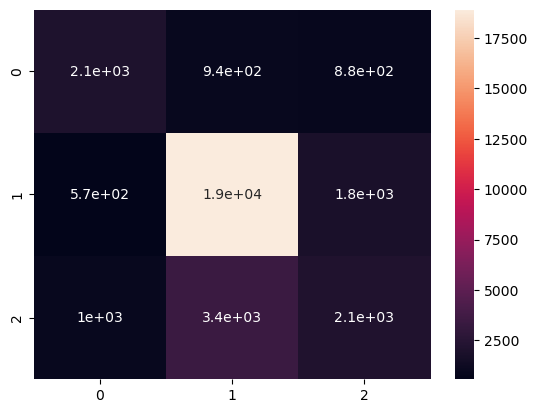

In [27]:
# check confusion matrix
helper.print_confusion_matrix_details(y_test, y_pred)

### Metrics: ROC-AUC Curve

In [28]:
# predict probabilities on the test set
y_pred_probs = knn_model.predict_proba(X_test_scaled)

In [29]:
# Convert y_test to one-hot encoded format
# Extract the class labels
classes = knn_model.classes_
y_test_onehot = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

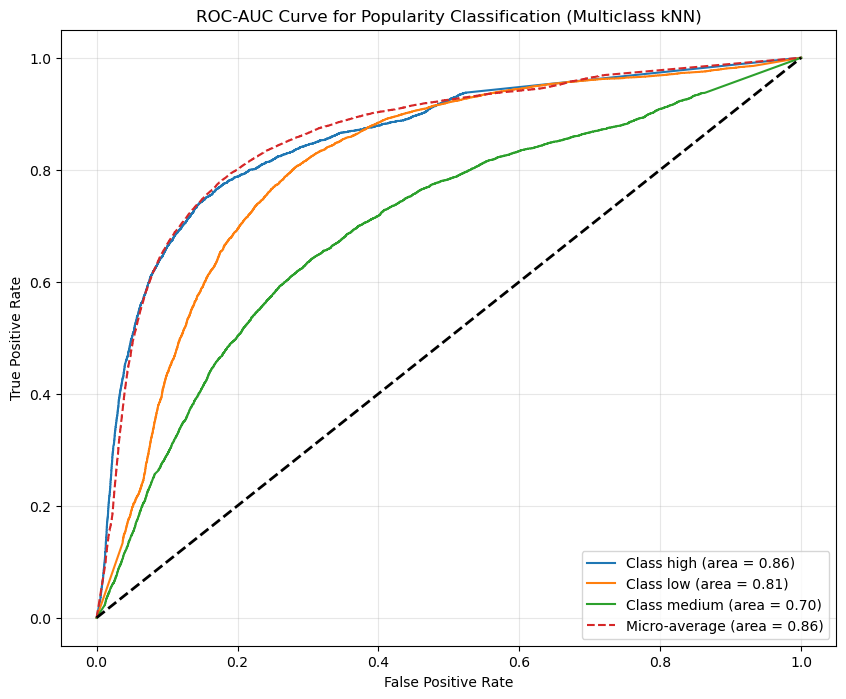

In [30]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_label} (area = {roc_auc[i]:.2f})")

# Add micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (area = {roc_auc['micro']:.2f})", linestyle='--')

# Plot the diagonal (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.title("ROC-AUC Curve for Popularity Classification (Multiclass kNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The area under the curve (AUC) of our ROC represents the model's overall performance, and we can see the difference in accuracy for different classes. The closer an AUC is to 1, the better it is at predicting between the correct classes, with our "high" popularity class having the best curve, and our average ROC curve has an area of 0.86. Although our model performs okay, there may be other models that perform better on this data.

## Ensemble Models
Let's explore how different ensemble models perform on this data. Ensemble models like Random Forests or Gradient Boosting (ex. XGBoost) often perform better on imbalanced data and can improve overall performance on minority classes.

### "Shotgun Approach:" Ensemble Models

In [31]:
# creating models that we want to test to see which is most optimized
# we will use this to test different X_train variations
ensemble_models = {
    "RandomForest": {
        "Estimator": RandomForestClassifier(),
        },
    "ADABoost": {
        "Estimator": AdaBoostClassifier(),
        }
}

In [32]:
# test performance of different models using X_train
helper.test_models_performance(ensemble_models, X_train, y_train, isRegressor=False)


[MODEL TYPE: RandomForest]

>>>> Top Performance: 		0.7492
>>>> Average Performance: 	0.7392
>>>> Spread of Performance: 	0.0049

[MODEL TYPE: ADABoost]

>>>> Top Performance: 		0.7469
>>>> Average Performance: 	0.7428
>>>> Spread of Performance: 	0.0030


In [33]:
# test performance of different models using X_train_scaled
helper.test_models_performance(ensemble_models, X_train_scaled, y_train, isRegressor=False)


[MODEL TYPE: RandomForest]

>>>> Top Performance: 		0.7469
>>>> Average Performance: 	0.7385
>>>> Spread of Performance: 	0.0045

[MODEL TYPE: ADABoost]

>>>> Top Performance: 		0.7469
>>>> Average Performance: 	0.7428
>>>> Spread of Performance: 	0.0030


### Accuracy Evaluation
Both ensemble models perform a little too well at 100% accuracy. Look at their confusion matrices and classification reports to understand better.

In [34]:
# Let's instantiate a Random Forest model
rf_model = RandomForestClassifier()
y_pred = helper.fit_predict(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	74.05%


confusion matrix:
 [[ 2174   807   898]
 [  531 18813  1930]
 [  964  3088  2458]]

              precision    recall  f1-score   support

        high       0.59      0.56      0.58      3879
         low       0.83      0.88      0.86     21274
      medium       0.47      0.38      0.42      6510

    accuracy                           0.74     31663
   macro avg       0.63      0.61      0.62     31663
weighted avg       0.72      0.74      0.73     31663



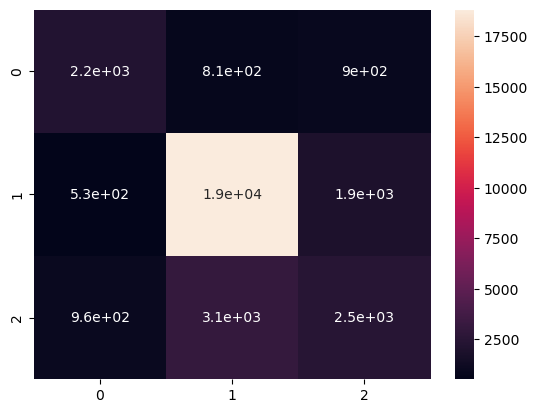

In [35]:
helper.print_confusion_matrix_details(y_test, y_pred)

This Random Forest model still isn't as good at predicting popularity index as the KNN model with scaled data.

#### Accuracy to beat: 76%

### Feature Importance

In [36]:
# let's see the importance of our features
# on our most successful random forest model

importances, features = rf_model.feature_importances_, X.columns

feature_importances = [(features[iteration], importances[iteration]) for iteration in range(len(features))]
feature_importances.sort(reverse=True, key=lambda X: X[1])

feature_importances

[('product_code', 0.48772249283896923),
 ('colour_group_code', 0.07733943425313469),
 ('product_type_no', 0.07115155976428836),
 ('department_no', 0.0675917417963747),
 ('graphical_appearance_no', 0.06202933284671913),
 ('perceived_colour_master_id', 0.057696548474695304),
 ('perceived_colour_value_id', 0.0479701088287652),
 ('section_no', 0.03871001419167362),
 ('garment_group_no', 0.029965031449325382),
 ('index_code', 0.02112810424276051),
 ('product_group_name', 0.019832794957638886),
 ('index_group_no', 0.01886283635565512)]

In [37]:
# split out feature_importances for our bar plot

x_features = [feature_importance[0] for feature_importance in feature_importances]
y_importances = [feature_importance[1] for feature_importance in feature_importances]

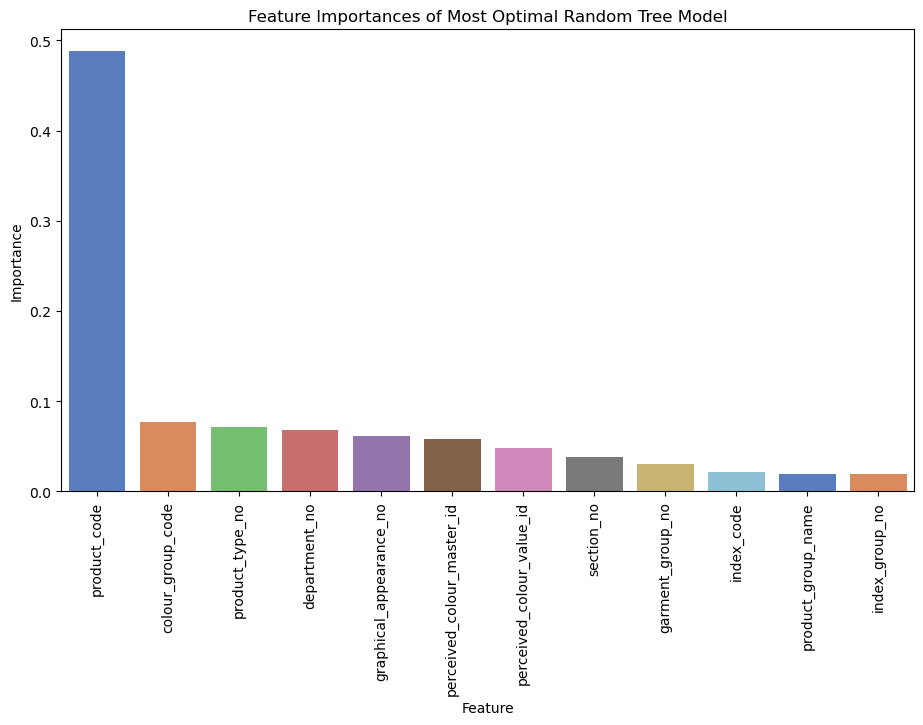

In [38]:
# Presentation Visual
# Plot the importance of each feature in our Random Forest model
plt.figure(figsize=(11, 6))

sns.barplot(x=x_features, y=y_importances, palette="muted")
plt.title("Feature Importances of Most Optimal Random Tree Model")
plt.xlabel("Feature")
plt.xticks(rotation=90)

plt.ylabel("Importance")
plt.show()

From this graph, we can see that product code is, by far, the most important feature to predict the popularity of an article of clothing.

## Artificial Neural Network (ANN)
Lastly, we want to see how an ANN would perform on this data.

In [46]:
# One-hot encode target variable (for multiclass classification)
y_onehot = pd.get_dummies(y)

In [47]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [48]:
# Number of features after preprocessing
input_dim = X_train.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train.shape[1]

input_dim, output_dim

(12, 3)

In [49]:
# Define the initial ANN model
ann_model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.3),  # Add dropout to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(output_dim,activation='softmax')  # Use softmax for multiclass classification
])

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
2309/2309 [==============================] - 7s 2ms/step - loss: 4761.4941 - accuracy: 0.6336 - val_loss: 1.7972 - val_accuracy: 0.6688
Epoch 2/50
2309/2309 [==============================] - 5s 2ms/step - loss: 12.0176 - accuracy: 0.6667 - val_loss: 1.2445 - val_accuracy: 0.6688
Epoch 3/50
2309/2309 [==============================] - 5s 2ms/step - loss: 3.2858 - accuracy: 0.6680 - val_loss: 0.8532 - val_accuracy: 0.6688
Epoch 4/50
2309/2309 [==============================] - 4s 2ms/step - loss: 2.0004 - accuracy: 0.6684 - val_loss: 0.8565 - val_accuracy: 0.6688
Epoch 5/50
2309/2309 [==============================] - 4s 2ms/step - loss: 1.9275 - accuracy: 0.6685 - val_loss: 0.8530 - val_accuracy: 0.6688
Epoch 6/50
2309/2309 [==============================] - 4s 2ms/step - loss: 1.0670 - accuracy: 0.6686 - val_loss: 0.8530 - val_accuracy: 0.6688
Epoch 7/50
2309/2309 [==============================] - 4s 2ms/step - loss: 1.0141 - accuracy: 0.6686 - val_loss: 0.8530 - val_accur

Test Accuracy: 0.68


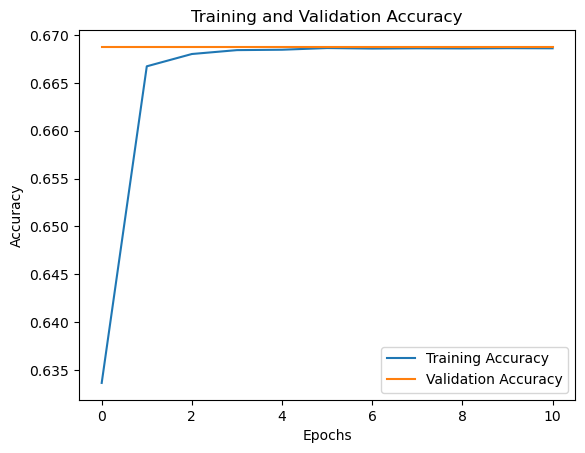

In [51]:
# Evaluate on the test set
test_loss, test_accuracy = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

495/495 [==============================] - 1s 1ms/step
confusion matrix:
 [[10687     0     0]
 [ 3195     0     0]
 [ 1950     0     0]]

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     10687
           1       0.00      0.00      0.00      3195
           2       0.00      0.00      0.00      1950

    accuracy                           0.68     15832
   macro avg       0.23      0.33      0.27     15832
weighted avg       0.46      0.68      0.54     15832



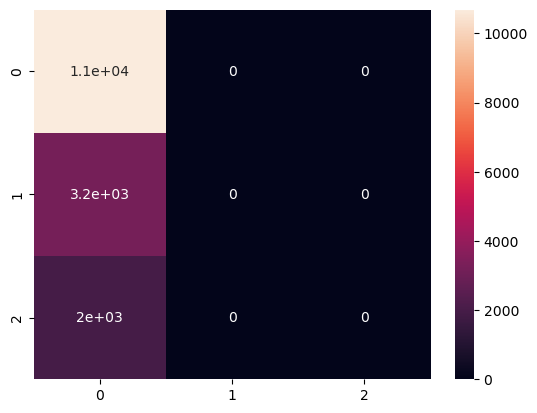

In [52]:
# Predict on test data
y_pred_probs = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Decode the predicted and true labels
y_test_classes = np.argmax(y_test.values, axis=1)

# Confusion Matrix
helper.print_confusion_matrix_details(y_test_classes, y_pred_classes)

#### Accuracy to beat: 68%

The metrics and confusion matrix show that there's a class imbalance and potential issues with the model's ability to generalize.

### Tuning: Class Weights
Let's try to assign higher weights to minority classes in the loss function and see if our model improves.

In [53]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.idxmax(axis=1)), y=y_train.idxmax(axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.710956993982093, 1: 0.49852895528833824, 2: 1.599424130241822}


In [54]:
# Train the model
history = ann_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

Epoch 1/50
2309/2309 [==============================] - 6s 2ms/step - loss: 1.2659 - accuracy: 0.6686 - val_loss: 1.0209 - val_accuracy: 0.6688
Epoch 2/50
2309/2309 [==============================] - 5s 2ms/step - loss: 1.0646 - accuracy: 0.6686 - val_loss: 1.0250 - val_accuracy: 0.6688
Epoch 3/50
2309/2309 [==============================] - 6s 3ms/step - loss: 1.2301 - accuracy: 0.6686 - val_loss: 1.0236 - val_accuracy: 0.6688
Epoch 4/50
2309/2309 [==============================] - 6s 2ms/step - loss: 1.3010 - accuracy: 0.6686 - val_loss: 1.0261 - val_accuracy: 0.6688
Epoch 5/50
2309/2309 [==============================] - 7s 3ms/step - loss: 1.0747 - accuracy: 0.6686 - val_loss: 1.0207 - val_accuracy: 0.6688
Epoch 6/50
2309/2309 [==============================] - 7s 3ms/step - loss: 1.0581 - accuracy: 0.6686 - val_loss: 1.0224 - val_accuracy: 0.6688
Epoch 7/50
2309/2309 [==============================] - 4s 2ms/step - loss: 1.2065 - accuracy: 0.6686 - val_loss: 1.0191 - val_accuracy:

In [55]:
# Evaluate on the test set
test_loss, test_accuracy = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.68


495/495 [==============================] - 0s 906us/step
confusion matrix:
 [[10687     0     0]
 [ 3195     0     0]
 [ 1950     0     0]]

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     10687
           1       0.00      0.00      0.00      3195
           2       0.00      0.00      0.00      1950

    accuracy                           0.68     15832
   macro avg       0.23      0.33      0.27     15832
weighted avg       0.46      0.68      0.54     15832



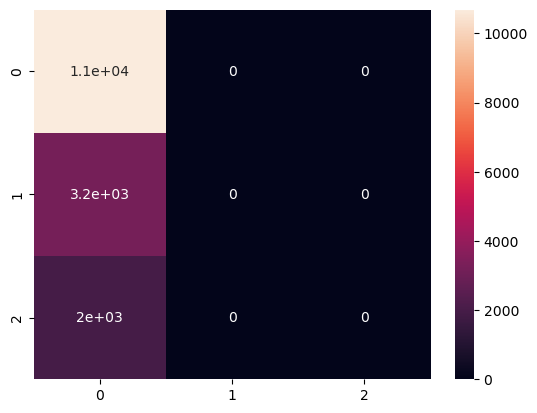

In [56]:
# Predict on test data
y_pred_probs = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Decode the predicted and true labels
y_test_classes = np.argmax(y_test.values, axis=1)

# Confusion Matrix
helper.print_confusion_matrix_details(y_test_classes, y_pred_classes)

Changing the class weights didn't improve the model at all.

#### Accuracy to beat: 68%

### Tuning: LeakyReLU
Let's add a LeakyReLU layer to our model to try improving model accuracy.

In [57]:
# add LeakyReLU with alpha 0.1 to model
leaky_model = Sequential([
    Dense(64, input_dim=input_dim),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(output_dim, activation='softmax')
])

# Compile the model
leaky_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

leaky_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [58]:
# Train the model
history = leaky_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
2309/2309 [==============================] - 6s 2ms/step - loss: 5092.3667 - accuracy: 0.5659 - val_loss: 61.9290 - val_accuracy: 0.6945
Epoch 2/50
2309/2309 [==============================] - 4s 2ms/step - loss: 86.7046 - accuracy: 0.5737 - val_loss: 16.9438 - val_accuracy: 0.7030
Epoch 3/50
2309/2309 [==============================] - 4s 2ms/step - loss: 26.4410 - accuracy: 0.5735 - val_loss: 3.5843 - val_accuracy: 0.6812
Epoch 4/50
2309/2309 [==============================] - 4s 2ms/step - loss: 7.9684 - accuracy: 0.5585 - val_loss: 1.6512 - val_accuracy: 0.6800
Epoch 5/50
2309/2309 [==============================] - 4s 2ms/step - loss: 3.9365 - accuracy: 0.5612 - val_loss: 0.9832 - val_accuracy: 0.6893
Epoch 6/50
2309/2309 [==============================] - 4s 2ms/step - loss: 2.5533 - accuracy: 0.5823 - val_loss: 2.4082 - val_accuracy: 0.7090
Epoch 7/50
2309/2309 [==============================] - 4s 2ms/step - loss: 1.5168 - accuracy: 0.6116 - val_loss: 0.8782 - val_ac

In [59]:
# Evaluate on the test set
test_loss, test_accuracy = leaky_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.71


495/495 [==============================] - 1s 932us/step
confusion matrix:
 [[9980  697   10]
 [1997 1194    4]
 [ 697 1247    6]]

              precision    recall  f1-score   support

           0       0.79      0.93      0.85     10687
           1       0.38      0.37      0.38      3195
           2       0.30      0.00      0.01      1950

    accuracy                           0.71     15832
   macro avg       0.49      0.44      0.41     15832
weighted avg       0.65      0.71      0.65     15832



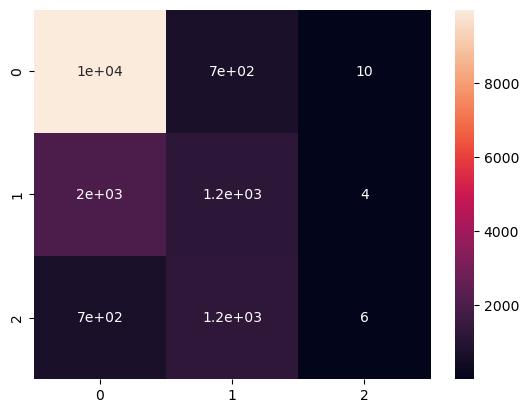

In [60]:
# Predict on test data
y_pred_probs = leaky_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Decode the predicted and true labels
y_test_classes = np.argmax(y_test.values, axis=1)

# Confusion Matrix
helper.print_confusion_matrix_details(y_test_classes, y_pred_classes)

This improved the model a bit!

#### Accuracy to beat: 73%

### Tuning: GridSearchCV

In [61]:
# define hyperparameters
hyperparameters = {
    'neurons': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.2, 0.4],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20]
}

In [62]:
# Define the ANN model
def create_model(neurons=64, optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))  # For multi-class classification

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [63]:
tuned_model = KerasClassifier(build_fn=create_model)
model_tuner = GridSearchCV(tuned_model, hyperparameters, cv=10, scoring="accuracy")

In [64]:
# model_tuner.fit(X_train, y_train)

The code for the grid search was commented out, as it didn't even finish overnight, but the accuracy oscillated between 62-67%, which is no better than our previous models.

In [65]:
# Most optimal ANN model: xxxx

# commenting this out because this will cause an error
# if the above cell is also commented out

# optimally_tuned_classifier = model_tuner.best_estimator_

# optimally_tuned_classifier

In [66]:
# commenting this out because this will cause an error
# if the above cell is also commented out

# Get accuracy of the most optimal classifier
# y_pred = optimally_tuned_classifier.predict(X_test_scaled)

# helper.print_accuracy(y_test, y_pred, isRegressor=False)

### Tuning: Learning Rate Scheduler
Lastly, we will try using a learning rate scheduler to adjust the learning rate dynamically.

In [67]:
# create learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [68]:
# add LRS to winning ANN leaky model 
history = leaky_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
2309/2309 [==============================] - 4s 2ms/step - loss: 0.8182 - accuracy: 0.6872 - val_loss: 0.7755 - val_accuracy: 0.6681 - lr: 0.0010
Epoch 2/50
2309/2309 [==============================] - 4s 2ms/step - loss: 0.8010 - accuracy: 0.6902 - val_loss: 0.7137 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 3/50
2309/2309 [==============================] - 4s 2ms/step - loss: 0.8130 - accuracy: 0.6863 - val_loss: 0.7161 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 4/50
2309/2309 [==============================] - 3s 1ms/step - loss: 0.8036 - accuracy: 0.6893 - val_loss: 0.7158 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 5/50
2309/2309 [==============================] - 7s 3ms/step - loss: 0.8060 - accuracy: 0.6896 - val_loss: 0.7012 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 6/50
2309/2309 [==============================] - 7s 3ms/step - loss: 0.8069 - accuracy: 0.6882 - val_loss: 0.7466 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 7/50
2309/2309 [==============================] - 5s

In [69]:
# Evaluate on the test set
test_loss, test_accuracy = leaky_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.71


495/495 [==============================] - 1s 1ms/step
confusion matrix:
 [[10057   622     8]
 [ 2053  1141     1]
 [  724  1226     0]]

              precision    recall  f1-score   support

           0       0.78      0.94      0.86     10687
           1       0.38      0.36      0.37      3195
           2       0.00      0.00      0.00      1950

    accuracy                           0.71     15832
   macro avg       0.39      0.43      0.41     15832
weighted avg       0.61      0.71      0.65     15832



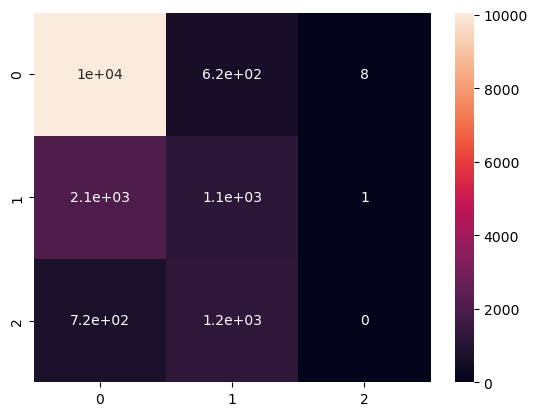

In [70]:
# Predict on test data
y_pred_probs = leaky_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Decode the predicted and true labels
y_test_classes = np.argmax(y_test.values, axis=1)

# Confusion Matrix
helper.print_confusion_matrix_details(y_test_classes, y_pred_classes)

The LRS didn't improve the performance of the ANN model.

# Summary

## Winning Model
The kNN was our winning model that performed the best with our fashion trends data and was able to predict with the highest accuracy (76%) whether an article of clothing was low, medium, or high popularity.

## Next Steps
Moving forward, we can implement some methods that could improve this model further:
- Feature Selection & Engineering: We only used descriptive data of each article of clothing and didn't use any metadata on the customers that purchased the clothing. Cherry picking customer features and creating a more comprehensive dataset for machine learning may provide more accurate predictions.
- Hyperparameter Tuning: Our accuracy score is not very high and may need more hyperparameter tuning. With more time, we can do a selective GridSearchCV with this model to understand which hyperparameters would be even better to put into our model.

If we are able to improve the accuracy of popularity predictions, we may be able to use this data to create a recommender system that can provide outfit recommendations based on trends.